In [ ]:
# https://medium.com/@black_swan/how-to-train-word2vec-and-fasttext-embedding-on-wikipedia-corpus-9e8ac45a0c0a
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [72]:
import pandas as pd
import praw
import re
import nltk
import gensim.models
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
df = pd.read_csv("../Data/wsb_cleaned.csv")

In [35]:
regex = re.compile('[^a-zA-Z ]')
for col in ['title', 'author', 'selftext']:
    df[col] = df[col].apply(lambda x : regex.sub('', str(x).lower() ))

In [114]:
text = df['title'].append(df['selftext'])

#sentences = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]
sentences = [x.split(' ') for x in text]

In [6]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lnajt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [115]:

model = gensim.models.Word2Vec(sentences = sentences,  min_count=10, vector_size=200, epochs = 4)


In [47]:
model_fasttext = gensim.models.FastText(sentences = sentences,  min_count=10, vector_size=200, epochs = 4)



In [48]:
for word, sim in model_fasttext.wv.most_similar(positive=['GME'], negative=[]):
    print('\"%s\"\t- similarity: %g' % (word, sim))
    print('')

"vive"	- similarity: 0.302227

"visualize"	- similarity: 0.300375

"teach"	- similarity: 0.296075

"edu"	- similarity: 0.295767

"learn"	- similarity: 0.292563

"warn"	- similarity: 0.292214

"educate"	- similarity: 0.288621

"remake"	- similarity: 0.282363

"visuals"	- similarity: 0.273877

"smoothie"	- similarity: 0.271559



In [49]:
for word, sim in model.wv.most_similar(positive=['gme'], negative=[]):
    print('\"%s\"\t- similarity: %g' % (word, sim))
    print('')

"amc"	- similarity: 0.584522

"nok"	- similarity: 0.571974

"bb"	- similarity: 0.565357

"gamestop"	- similarity: 0.539042

"cashapp"	- similarity: 0.518773

"pltr"	- similarity: 0.482038

"shares"	- similarity: 0.480966

"gmeamc"	- similarity: 0.459523

"tsla"	- similarity: 0.452893

"it"	- similarity: 0.451687



In [50]:
for word, sim in model_fasttext.wv.most_similar(positive=['tendies']):
    print('\"%s\"\t- similarity: %g' % (word, sim))
    print('')

"tendiesyall"	- similarity: 0.912922

"tendiez"	- similarity: 0.869282

"undies"	- similarity: 0.808194

"tendieland"	- similarity: 0.807916

"tendys"	- similarity: 0.800977

"tendie"	- similarity: 0.792897

"trendies"	- similarity: 0.778332

"bodies"	- similarity: 0.771447

"tendietown"	- similarity: 0.76978

"tendy"	- similarity: 0.764926



In [51]:
for word, sim in model.wv.most_similar(positive=['tendies']):
    print('\"%s\"\t- similarity: %g' % (word, sim))
    print('')

"trendies"	- similarity: 0.731896

"gains"	- similarity: 0.604199

"bananas"	- similarity: 0.594028

"monies"	- similarity: 0.581953

"tenders"	- similarity: 0.57616

"gainz"	- similarity: 0.570759

"money"	- similarity: 0.541298

"profits"	- similarity: 0.530584

"crayons"	- similarity: 0.519749

"dreams"	- similarity: 0.516581



In [52]:
for word, sim in model.wv.most_similar(positive=['normies']):
    print('\"%s\"\t- similarity: %g' % (word, sim))
    print('')

"boomers"	- similarity: 0.706596

"redditors"	- similarity: 0.635294

"journalists"	- similarity: 0.633112

"shills"	- similarity: 0.632009

"millennials"	- similarity: 0.622998

"algos"	- similarity: 0.617824

"wsbers"	- similarity: 0.600478

"elites"	- similarity: 0.592713

"rinvesting"	- similarity: 0.585464

"fags"	- similarity: 0.572962



In [53]:
for word, sim in model.wv.most_similar(positive=['autist', 'friends'], negative = ['tendies']):
    print('\"%s\"\t- similarity: %g' % (word, sim))
    print('')

"redditor"	- similarity: 0.567007

"retard"	- similarity: 0.563351

"idiot"	- similarity: 0.542493

"tard"	- similarity: 0.525727

"ape"	- similarity: 0.520383

"dumbass"	- similarity: 0.514155

"brother"	- similarity: 0.50391

"degenerate"	- similarity: 0.501423

"member"	- similarity: 0.499434

"family"	- similarity: 0.480303



In [9]:
## Saving and loading

import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

Some preliminary regression /classification below -- this is slated to get moved

In [92]:
def average_vector(text, model):
    present_keys = [x for x in text if x in model.wv.key_to_index ]
    if not present_keys:
        return [0] * len( model.wv[ model.wv.index_to_key[0]])
    return sum( [model.wv[x] for x in present_keys] ) /len(present_keys)

In [93]:
df['avg_vector'] = df['title'].apply(lambda x : average_vector(x, model))

In [94]:
X = np.vstack(df['avg_vector'].to_numpy())
y = df['ups']

In [95]:
X

array([[-0.09697723, -0.27556565, -0.30408973, ..., -0.3428641 ,
        -0.29756173,  0.11251496],
       [-0.13743488, -0.2939136 , -0.20476417, ..., -0.40239561,
        -0.15918866,  0.09810434],
       [-0.1768456 , -0.38518009, -0.50580472, ..., -0.14900006,
        -0.45622417, -0.0221975 ],
       ...,
       [-0.16225435, -0.29625562, -0.31762227, ..., -0.19057961,
        -0.18930106,  0.39942399],
       [-0.0425817 , -0.45177734, -0.28937829, ..., -0.39290038,
        -0.31684643,  0.12985335],
       [ 0.07859053, -0.45629492, -0.3879267 , ..., -0.42176488,
        -0.3865892 , -0.03404421]])

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [97]:
from sklearn.metrics import mean_squared_error

# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

3505836.8947012136

In [100]:

plot = pd.DataFrame([y_pred, y_test])

<AxesSubplot:xlabel='0', ylabel='1'>

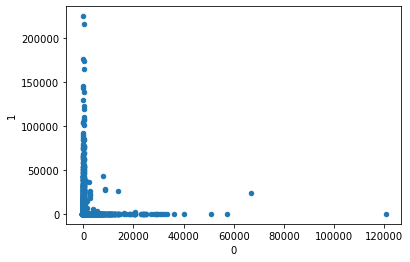

In [106]:
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [113]:
df[df.ups >= 300000]

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups,total_awards_received,num_comments,num_crossposts,is_self,is_video,media_only,id,created_utc,selftext_html,author_fullname,avg_vector
529648,230376,upvote so everyone sees we got support,vrweensy,2021-01-28 13:40:34,nan,https://i.redd.it/sgoqy8nyt2e61.png,0.97,314804,1270,12832,41,False,False,False,l6wu59,1.611841e+09,NaN,t2_6d70j6ko,"[-0.2506461, -0.100870706, -0.4655382, 0.51839..."
708272,409000,times square right now,someguyindeutschland,2021-01-30 18:00:38,nan,https://v.redd.it/x64z70f7eie61,0.98,411137,3510,12445,86,False,True,False,l8rf4k,1.612030e+09,NaN,t2_cxhbp,"[-0.060425878, -0.502828, -0.35687152, 0.39569..."


In [112]:
from datetime import datetime
datetime.now().strftime("%H:%M:%S")

'03:27:15'